In [5]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt

In [6]:
# Fetch JSON data from the URL
headers = {
    'User-Agent': 'Mozilla/5.0'
}
url = "https://query1.finance.yahoo.com/v7/finance/chart/spy?dataGranularity=1m&range=1d"
response = requests.get(url, headers=headers)
print(response.status_code)  # Should be 200 for a successful request
json_data = response.json()

# Extract relevant information from the JSON response
timestamps = json_data['chart']['result'][0]['timestamp']
close_prices = json_data['chart']['result'][0]['indicators']['quote'][0]['close']

# Create a DataFrame
df = pd.DataFrame({
    'time_key': pd.to_datetime(timestamps, unit='s'),
    'close': close_prices
})

# Calculate EMA
def calculate_ema(df, period):
    return df['close'].ewm(span=period, adjust=False).mean()

# Revised RSI calculation
def calculate_rsi(df, period=6):
    delta = df['close'].diff()
    gains = pd.Series(0, index=delta.index)
    losses = pd.Series(0, index=delta.index)
    
    gains[delta > 0] = delta[delta > 0]
    losses[delta < 0] = -delta[delta < 0]
    
    avg_gains = gains.rolling(window=period, min_periods=period).mean()
    avg_losses = losses.rolling(window=period, min_periods=period).mean()
    
    rs = avg_gains / np.where(avg_losses == 0, 0.000001, avg_losses)
    rsi = 100 - (100 / (1 + rs))
    
    return avg_gains, avg_losses, rsi

200


In [7]:
# Append EMA to DataFrame
df['EMA_5'] = calculate_ema(df, 5)
df['EMA_10'] = calculate_ema(df, 10)
df['EMA_15'] = calculate_ema(df, 15)
df['EMA_20'] = calculate_ema(df, 20)

# Calculate RSI and gain/loss
df['Gain'], df['Loss'], df['RSI'] = calculate_rsi(df)

# Select the last 60 rows
df = df.tail(60).reset_index(drop=True)

# Drop rows with NaN values
df = df.dropna(subset=['EMA_5', 'EMA_10', 'EMA_15', 'EMA_20', 'RSI']).reset_index(drop=True)

/var/folders/ml/htb8_zlj5354tptfyvsx5dr80000gn/T/ipykernel_11762/454050216.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.11999512 0.11999512 0.44006348 0.26989746 0.38000488 0.09002686
 0.17993164 0.27996826 0.53515625 0.03997803 0.51422119 0.40997314
 0.19000244 0.05999756 0.30499268 0.24005127 0.04998779 0.2800293
 0.34997559 0.02996826 0.17999268 0.02001953 0.15997314 0.7300415
 0.08996582 0.02990723 0.35748291 0.51013184 0.2598877  0.13500977
 0.0199585  0.19000244 0.58001709 0.29431152 0.0199585  0.12921143
 0.01080322 0.53997803 0.24017334 0.2666626  0.12280273 0.05010986
 0.30004883 0.05499268 0.26000977 0.13500977 0.15661621 0.0199585
 0.04003906 0.09997559 0.06988525 0.51977539 0.19622803 0.04376221
 0.22009277 0.23504639 0.13500977 0.21496582 0.10003662 0.14001465
 0.38989258 0.08007812 0.02001953 0.1151123  0.46002197 0.19995117
 0.05010986 0.38500977 0.06976318 0.14001465 0.10498047

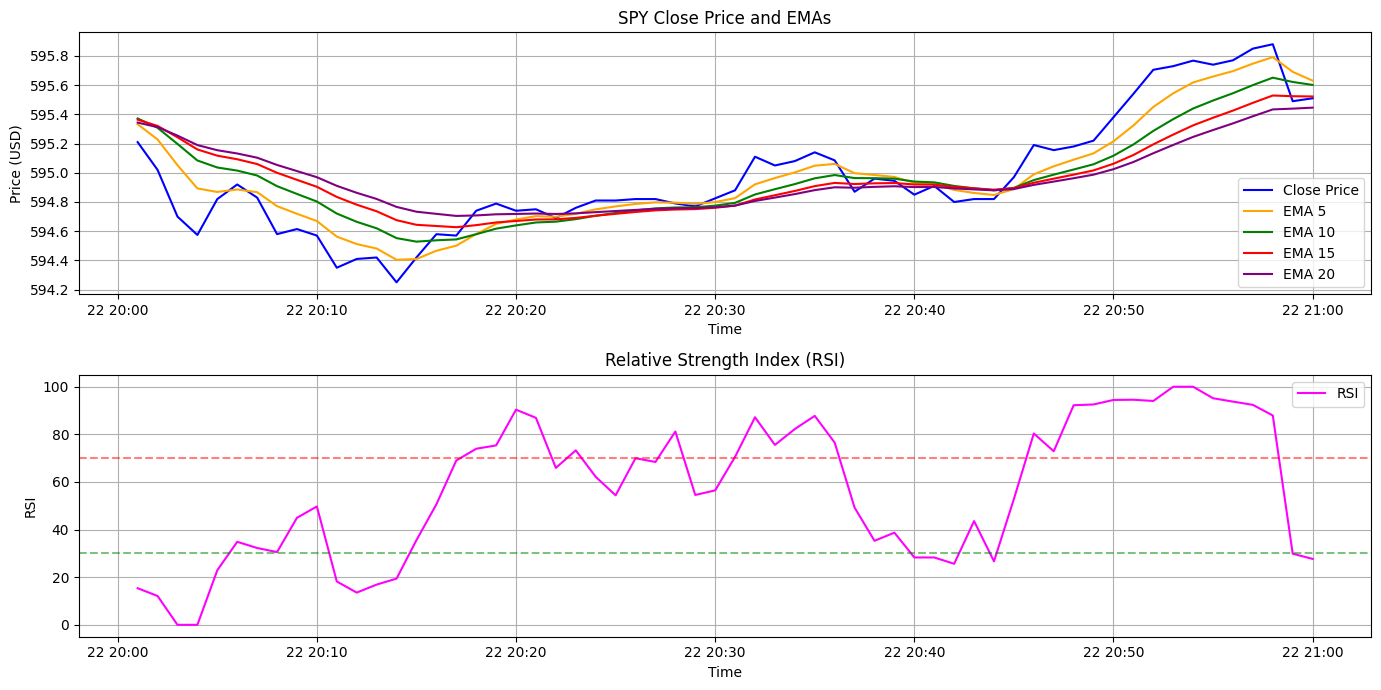

In [8]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot closing prices and EMAs
plt.subplot(2, 1, 1)
plt.plot(df['time_key'], df['close'], label='Close Price', color='blue')
plt.plot(df['time_key'], df['EMA_5'], label='EMA 5', color='orange')
plt.plot(df['time_key'], df['EMA_10'], label='EMA 10', color='green')
plt.plot(df['time_key'], df['EMA_15'], label='EMA 15', color='red')
plt.plot(df['time_key'], df['EMA_20'], label='EMA 20', color='purple')
plt.title('SPY Close Price and EMAs')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(df['time_key'], df['RSI'], label='RSI', color='magenta')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()